## 1. Upload the data nd libraries

### 1.1 Imports necessary libraries

In [1]:
# Python
from datetime import datetime
from pathlib import Path
import random
import sys

# Third party
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.iolib.table import SimpleTable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

def print_project_root():
    notebooks_dir = Path.cwd()

    # Calculate the root directory of the project (go up two levels)
    project_root = notebooks_dir.parent.parent
    print(f"The root directory of the project is: {project_root}")

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

print_project_root()

# Local imports
from pipeline.src._csv_utils import DataPathCleaningManager
from pipeline.src.model.model_io_operations import ModelManager

### 1.2 Import the data

In [2]:
data_timeplace = os.getenv("MARKET_OFFERS_TIMEPLACE")
if data_timeplace is None:
    raise ValueError("The environment variable MARKET_OFFERS_TIMEPLACE is not set.")

data_path_manager = DataPathCleaningManager(data_timeplace)
df = data_path_manager.load_cleaned_df(domain="combined")

In [3]:
# choose relevant columns
df.columns.tolist()

[('listing', 'link'),
 ('listing', 'title'),
 ('listing', 'summary_description'),
 ('listing', 'remote_service'),
 ('pricing', 'price'),
 ('pricing', 'rent'),
 ('pricing', 'total_rent'),
 ('pricing', 'total_rent_sqm'),
 ('pricing', 'deposit'),
 ('pricing', 'deposit_ratio'),
 ('location', 'complete_address'),
 ('location', 'street'),
 ('location', 'city'),
 ('location', 'voivodeship'),
 ('size', 'square_meters'),
 ('size', 'number_of_rooms'),
 ('size', 'floor'),
 ('size', 'attic'),
 ('size', 'building_floors'),
 ('legal_and_availability', 'available_from'),
 ('legal_and_availability', 'completion'),
 ('legal_and_availability', 'ownership'),
 ('legal_and_availability', 'rent_to_students'),
 ('type_and_year', 'building_type'),
 ('type_and_year', 'build_year'),
 ('amenities', 'elevator'),
 ('amenities', 'parking_space'),
 ('equipment', 'no_information'),
 ('equipment', 'stove'),
 ('equipment', 'fridge'),
 ('equipment', 'furniture'),
 ('equipment', 'oven'),
 ('equipment', 'washing_machine')

### 1.3 Remove outliers
In our scenario, it's not necessary to have a model that perfectly aligns with every specific local case. Instead, we need a model that is well-suited for our case the average situation.

In [4]:
def filter_relevant_rows(row):
    try:
        city = row['location']['city']
        building_type = row['type_and_year']['building_type'] if pd.notna(row['type_and_year'].get('building_type')) else False
        # build_year = row['type_and_year']['build_year'] if pd.notna(row['type_and_year'].get('build_year')) else False
        total_rent = row['pricing']['total_rent']
        return city in ["będziński", "Zawada", "Siewierz", "tarnogórski", "Piekary Śląskie", "zawierciański", "Siemianowice Śląskie"] \
        and building_type in ["block_of_flats", "apartment_building"] \
        and total_rent <= 4000
        # and build_year <= 1970
    except KeyError:
        return False

narrowed_df = df[df.apply(filter_relevant_rows, axis=1)].copy()

### 1.4 Convert a year of the building to years old

In [5]:
def calculate_building_age(build_year_series: pd.Series) -> pd.Series:
    """
    Convert a series of building years to building ages.
    
    :param build_year_series: A pandas Series containing building years.
    :return: A pandas Series containing building ages.
    """
    current_year = datetime.now().year
    
    # Calculate the age of the building by subtracting the year from the current year
    # If the value is np.nan, it remains np.nan
    building_age_series = build_year_series.apply(lambda x: current_year - x if np.isfinite(x) else np.nan)
    
    return building_age_series

# Assuming narrowed_df is a DataFrame with MultiIndex columns
new_values = calculate_building_age(narrowed_df['type_and_year']['build_year'])

# Use .loc to set the values
narrowed_df.loc[:, ('type_and_year', 'build_year')] = new_values

In [6]:
narrowed_df['type_and_year']['build_year'].describe()

count    20.000000
mean     26.500000
std      27.340927
min       1.000000
25%       1.750000
50%      20.000000
75%      44.000000
max      94.000000
Name: build_year, dtype: float64

### 1.5 Select relevant data

It's an iterative process. During the exploration of data through the various models you will find out which one works and not.

In [7]:
# relevant but multicollinearity:
# level 1 - very high
# level 2 - high

df_model = pd.DataFrame()

columns_to_select = [
    # ('pricing', 'total_rent'),
    ('pricing', 'total_rent_sqm'),
    # ('location', 'city'),
    ('size', 'square_meters'),
    # ('size', 'number_of_rooms'), # level 1
    # ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    # ('amenities', 'elevator'),
    # ('amenities', 'parking_space'),
    # ('equipment', 'furniture'), # level 1
    # ('equipment', 'stove'), # level 1
    # ('equipment', 'oven'),
    # ('equipment', 'washing_machine'),
    # ('equipment', 'TV'),
    ('equipment', 'dishwasher'),
    # ('media_types', 'internet'), # level 2
    # ('media_types', 'cable_TV'), # level 2
    # ('heating', 'district'),
    # ('security', 'monitoring_or_security'),
    # ('security', 'anti_burglary_doors_or_windows'), # level 2
    # ('security', 'enclosed_area'), # level 2
    # ('windows', 'aluminum'),
    # ('size', 'floor'),
    # ('size', 'building_floors'), # level 1
    # ('additional_information', 'air_conditioning'),
    # ('additional_information', 'utility_room'),
]

extracted_columns = narrowed_df.loc[:, columns_to_select]


extracted_columns.columns = extracted_columns.columns.droplevel(0)


df_model[extracted_columns.columns] = extracted_columns

In [8]:
df_model.dtypes

total_rent_sqm    Float64
square_meters       Int64
build_year        float64
dishwasher           bool
dtype: object

## 2. Get dummy data

Transforms categorical variables into numerical form by creating binary (`True`/`False`) indicator variables for each category, resulting in a new DataFrame called `df_dum`

In [9]:
df_dum = pd.get_dummies(df_model)

In [10]:
df_dum.dtypes

total_rent_sqm    Float64
square_meters       Int64
build_year        float64
dishwasher           bool
dtype: object

## 3. Training and Testing Data Separation
This step divides our data into two groups: one for training our model (learning from examples) and the other for testing it (checking how well it learned). We use a tool called `train_test_split` for this division, ensuring that our model can be trained on one part of the data and then evaluated on a different part to see how well it predicts new, unseen information.

In [11]:
# Splitting the dataset into features (X) and target variable (Y), where 'total_rent' is the target.
X = df_dum.drop('total_rent_sqm', axis =1)
Y = df_dum['total_rent_sqm']

# Converting boolean columns to integers for model compatibility. Models typically require numerical input.
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Replacing infinite values with NaN in the features to avoid errors during model training.
X = X.replace([np.inf, -np.inf], np.nan)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the feature set. Note: It's important to do this before the train-test split.
X_imputed = knn_imputer.fit_transform(X)
X_imputed = X_imputed.astype(float)

# Now, handle the target variable
Y = Y.replace([np.inf, -np.inf], np.nan)
Y = Y.fillna(0)

# Splitting the dataset into training and testing sets for model validation.
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y.values, test_size=0.2, random_state=42)

In [12]:
my_xnames = pd.Index(['total_rent_sqm'] + X.columns.tolist())

## 4. Multiple Linear Regression
This section implements a Multiple Linear Regression model using the Ordinary Least Squares (OLS) method from the statsmodels library. In this approach, the model aims to establish a linear relationship between multiple independent variables (features) and a single dependent variable (target). The OLS method is employed to determine the line of best fit, which is achieved by minimizing the sum of the squares of the residuals - the differences between the observed values and the values predicted by the model. This process allows for an efficient and effective way to understand how each independent variable contributes to the dependent variable, facilitating predictions and insights into the underlying data relationships.

In [14]:
# Convert Y_train to a numpy array if it's not already
Y_train_np = Y_train.to_numpy(dtype='float64')

# Adding a constant to the feature set and constructing the OLS model
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(Y_train_np, X_train_sm)

# You can name the variables in your model for better readability
# Assuming 'X' is defined and includes the names of your features
model.data.xnames = ['Intercept'] + X.columns.tolist()

In [15]:
results = model.fit().summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     11.45
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.29e-05
Time:                        15:32:38   Log-Likelihood:                -165.42
No. Observations:                  46   AIC:                             338.8
Df Residuals:                      42   BIC:                             346.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        73.2088      6.337     11.553      0.000      60.421      85.997
square_meters    -0.4336      0.093     -4.649      0.000      -0.622      -0.245
build_year       -0.3070      0.091     -3.360      0.002      -0.491      -0.123
dishwasher        6.2343      3.342      1.865      0.069      -0.510      12.979
==============================================================================
Omnibus:                        1.467   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.480   Jarque-Bera (JB):                0.653
Skew:                          -0.086   Prob(JB):                        0.722
Kurtosis:                       3.557   Cond. No.                         283.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

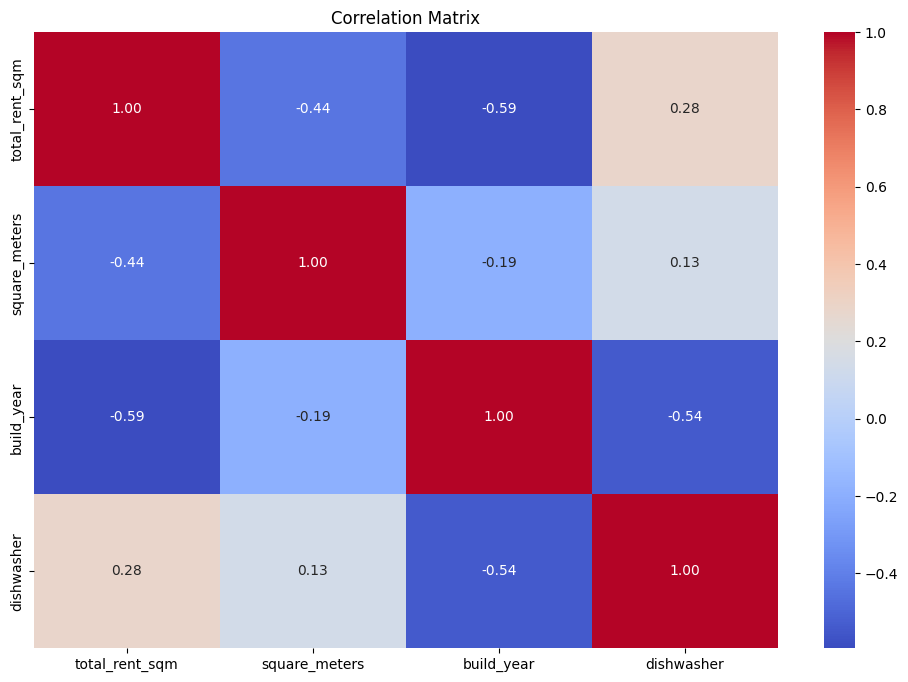

In [16]:
corr_matrix = df_model.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

This heatmap is a correlation matrix displaying how closely the variables in our dataset are related to each other.<br>
It's used here to detect multicollinearity, where some features might be too similar, providing overlapping information.<br>
We're looking for highly correlated features (close to 1 or -1) to consider removing them, reducing multicollinearity,<br>
and improving our model's reliability.


In [17]:
def get_t_results(results, t_cap):
    table_index = 1

    table_data = results.tables[table_index].data

    filtered_data = [row for row in table_data if float(row[-2].replace("[", "")) >= t_cap]

    sorted_data = sorted(filtered_data, key=lambda x: float(x[-2].replace("[", "")), reverse=True)

    filtered_table = SimpleTable(sorted_data, title=results.tables[table_index].title)

    print(f"passed_t_variables: {len(filtered_data)}")
    print(f"variables: {len(table_data)}")
    print(f"percentage: {round((len(filtered_data) / len(table_data)) * 100, 2)}")
    return filtered_table

get_t_results(results, 0.05)

passed_t_variables: 1
variables: 5
percentage: 20.0


Intercept,73.2088,6.337,11.553,0.000,60.421,85.997


In [18]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

np.mean(cross_val_score(lm,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv=10))

-7.425078567759298

## 5. Save model and validate it on selected sample

### 5.1 Check model on an example entry

In [28]:
random_sample = X_test[random.randint(0, X_test.shape[1])]

In [29]:
random_sample

array([49. , 28.4,  1. ])

In [30]:
list(random_sample)

[49.0, 28.4, 1.0]

In [31]:
model= lm
random_sample = X_test[random.randint(0, X_test.shape[0]-1)]  # Use shape[0] for the number of rows
prediction = model.predict(random_sample.reshape(1, -1))
print("Prediction:", prediction)

Prediction: [58.8856572]


### 5.2 Save the model and validate it

In [32]:

model = lm_l
training_data = X

# Construct the model_path relative to the current script/notebook directory
current_path = Path().resolve()
parent_dir = current_path.parent
model_path = str(parent_dir / 'model' / 'model.pkl')

model_manager = ModelManager(model_path=model_path, model=model, training_data=training_data)

In [33]:
model_manager.save_model_and_metadata()

In [34]:
model, metadata = model_manager.load_model_and_metadata()

In [35]:
metadata

{'columns': {'square_meters': 'Int64',
  'build_year': 'float64',
  'dishwasher': 'int32'},
 'column_order': ['square_meters', 'build_year', 'dishwasher']}

In [36]:
model.predict(random_sample.reshape(1, -1))

c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


array([58.8559577])

In [37]:
random_sample

array([46.,  2.,  1.])

In [38]:
model_manager.evaluate_model_on_sample(random_sample.reshape(1, -1), model)

Prediction: [58.8559577]


c:\Users\karol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
